<table cellspacing="0" cellpadding="0">
  <tr>
    <td>
        IA369Y - Computação Afetiva <br /> <br />
        T2 - Análise de Sentimentos em Textos <br /><br />
        Profª: Paula Dornhofer Paro Costa <br /><br />
        Alunos: Diego Cardoso Alves<br />
        Murilo Marin Pechoto<br />
    </td>
  </tr>
</table>

### Objetivo
O objetivo desta tarefa é expor os alunos aos desafios práticos envolvidos na análise de textos e na atribuição de valores de valência ou rótulos de emoções a sentenças.
Não é objetivo desta tarefa avaliar a acurácia de detecção ou a eficiência do modelo implementado mas a análise crítica do projeto e o amadurecimento em relação ao problema.


### Problema 1 - Determinação de Valência em Manchetes de Jornais Brasileiros no 1° Semestre de 2017

* Serão fornecidas 500 manchetes dos jornais “Valor Ecônomico”, “O Globo”, “Folha de São Paulo”, “O Estado de São Paulo”, extraídas em datas específicas dos meses de dezembro de 2016 a agosto de 2017. O acesso à base deve ser realizado pelo link: https://github.com/pdpcosta/manchetesBrasildatabase

* O problema consiste em classificar as manchetes em valência positiva, neutra ou negativa, associado ao indicador de intensidade. Exemplo: numa escala de -100  a 100, uma manchete classificada como +80 pode ser considerada muito positiva e uma manchete classificada como 5 pode ser considerada neutra.

* A tarefa consiste em definir a abordagem ao problema, o modelo de classificação, as regras de análise e deverá realizar uma implementação prática do algoritmo definido.

## Introdução

Ao longo deste Jupyter Notebook será demonstrado uma análise do dataset fornecido, buscando extrair informações que possam ser relevantes do ponto de vista de métricas e, também, em busca de erros ou padrões que possam auxiliar na análise de sentimentos. Serão descritas as bibliotecas utilizadas e os resultados obtidos.

## Bibliotecas

Foram utilizadas diversas bibliotecas para nos auxiliar na tarefa de determinar a valência em manchetes de jornais.
Abaixo, apresentamos uma breve descrição de cada uma delas

In [83]:
import numpy as np  #Numpy para cálculos númericos
import pandas as pd #Pandas é uma ferramente muito útil para análise de dados
pd.set_option('display.max_columns', None) #Parâmetro para exibir todas as colunas
pd.set_option('display.max_colwidth', -1)

%matplotlib inline
import matplotlib.pyplot as plt #Matplot é uma biblioteca clássica do Python para plotagem de gráficos
import seaborn as sns #Seaborn é uma ótima ferramenta para gráficos de análise de dados

import nltk #NLTK é uma biblioteca de processamento de linguagem natural
from nltk.tokenize import word_tokenize #"Tokeniza" uma string para separar a pontuação além dos períodos.

from wordcloud import WordCloud #Biblioteca para criar nuvem de palavras

import requests #Requests é uma biblioteca HTTP para Python
import re #Biblioteca para trabalhar com expressões regulares
from bs4 import BeautifulSoup #BeautifulSoup é uma biblioteca Python para extrair dados de arquivos HTML e XML

## Leitura do Dataset

Arquivo original de dados obtido através de https://github.com/pdpcosta/manchetesBrasildatabase [1].

O arquivo .CSV foi lido através de um método do Pandas, onde já podemos atribuir cabeçalhos às colunas.

Logo abaixo, podemos ver as colunas e algumas amostras do dataset.

In [84]:
df = pd.read_csv("manchetesBrasildatabase.csv", quotechar="'", header = None, names = ["Day", "Month", "Year", "Company", "Headline"])

In [85]:
df.head()

,Day,Month,Year,Company,Headline
0,1,fevereiro,2017,Valor,BNDES encolhe e volta ao nível de 20 anos atrás
1,1,fevereiro,2017,Valor,BC cria novo instrumento de política monetária.
2,1,fevereiro,2017,Valor,Câmbio gera bate-boca entre UA e UE.
3,1,fevereiro,2017,Valor,Indenização a transmissoras de energia já chega à tarifa.
4,1,fevereiro,2017,Valor,"Políticos esperam que relator separe ""joio do trigo""."


# Análise Textual

Primeiramente, vamos apresentar uma análise textual baseado no tamanho das sentenças de cada manchete de notícia.

### Criação de uma nova coluna para o tamanho de cada manchete

A função abaixo faz o split de cada manchete, conta as palavras e atribui o valor númerico a uma nova coluna (Lenght)

In [86]:
df['Length'] = df['Headline'].apply(lambda x: len(x.split()))
df.head()

,Day,Month,Year,Company,Headline,Length
0,1,fevereiro,2017,Valor,BNDES encolhe e volta ao nível de 20 anos atrás,10
1,1,fevereiro,2017,Valor,BC cria novo instrumento de política monetária.,7
2,1,fevereiro,2017,Valor,Câmbio gera bate-boca entre UA e UE.,7
3,1,fevereiro,2017,Valor,Indenização a transmissoras de energia já chega à tarifa.,9
4,1,fevereiro,2017,Valor,"Políticos esperam que relator separe ""joio do trigo"".",8


### Número médio de palavras

O gráfico abaixo ilustra o número médio de palavras utilizadas nas manchetes de cada Jornal

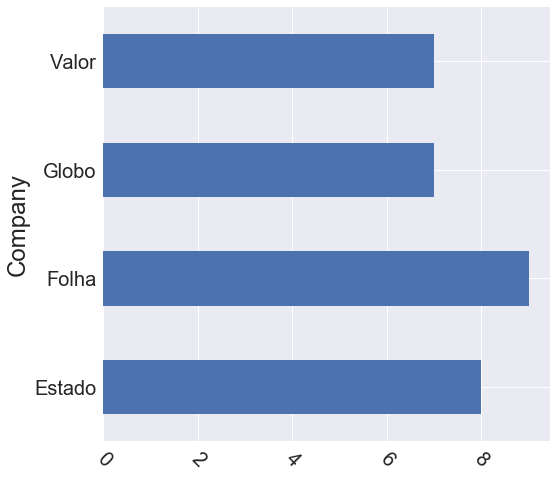

In [87]:
ax = df.groupby("Company")["Length"].median().plot(kind="barh", figsize=(8, 8))

# resize y label
ylabel = ax.yaxis.get_label()
ylabel.set_fontsize(24)

# resize x tick labels
labels = ax.yaxis.get_ticklabels()
[label.set_fontsize(20) for label in labels];

# resize y tick labels
labels = ax.xaxis.get_ticklabels()
[label.set_fontsize(20) for label in labels]
[label.set_rotation(-45) for label in labels];

Claramente podemos ver que a "Folha de São Paulo", na média, é o Jornal que utiliza mais palavras em suas manchetes.

### Criação de uma nova coluna para o tamanho de cada manchete - Stopwords

Stopwords: São palavras que podem ser consideradas irrelevantes para o conjunto de resultados a ser exibido em uma busca realizada em uma search engine [2]. Estas palavras são usadas para definir a estrutura de uma frase. Mas, não são de nenhum uso em definir o contexto.
Alguns exemplos de Stopwords:
* Linguagem – a, o, de, da, que, em, um.

Vamos repetir a mesma análise anterior, porém retirando as "stopwords". Para isso vamos utilizar um método da biblioteca NLTK, que nos fornece facilmente algumas stopwords da Língua Portuguesa.

A função abaixo faz o split de cada manchete, conta as palavras sem as stopwords e atribui o valor númerico a uma nova coluna (Lenght_Filtered)

In [88]:
stopwords = nltk.corpus.stopwords.words('portuguese')
df['Length_Filtered'] = df['Headline'].apply(lambda x: len(set(x.split()).difference(stopwords)) )
df.head()

,Day,Month,Year,Company,Headline,Length,Length_Filtered
0,1,fevereiro,2017,Valor,BNDES encolhe e volta ao nível de 20 anos atrás,10,7
1,1,fevereiro,2017,Valor,BC cria novo instrumento de política monetária.,7,6
2,1,fevereiro,2017,Valor,Câmbio gera bate-boca entre UA e UE.,7,5
3,1,fevereiro,2017,Valor,Indenização a transmissoras de energia já chega à tarifa.,9,5
4,1,fevereiro,2017,Valor,"Políticos esperam que relator separe ""joio do trigo"".",8,6


### Número médio de palavras sem stopwords

O gráfico abaixo ilustra o número médio de palavras utilizadas nas manchetes de cada Jornal


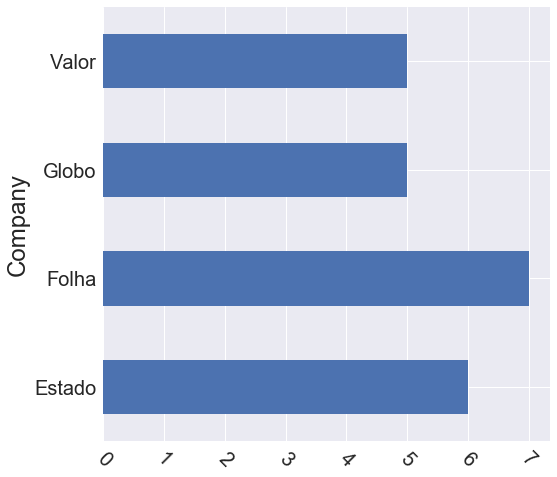

In [89]:
ax = df.groupby("Company")["Length_Filtered"].median().plot(kind="barh", figsize=(8, 8))

# resize y label
ylabel = ax.yaxis.get_label()
ylabel.set_fontsize(24)

# resize x tick labels
labels = ax.yaxis.get_ticklabels()
[label.set_fontsize(20) for label in labels];

# resize y tick labels
labels = ax.xaxis.get_ticklabels()
[label.set_fontsize(20) for label in labels]
[label.set_rotation(-45) for label in labels];

Mesmo após a remoção das stopwors, o jornal "Folha de São Paulo" ainda tem o maior número médio de palavras em suas manchetes.

Esta pré análise vai nos ajudar a verificar se o número de palavras foi um fator relevante ou não na determinação da valência de cada manchete. 

# POS Tagging - Análise usando MAC Morpho

Mac-Morpho é um corpus de textos em português brasileiro anotado com tags de part-of-speech. Sua primeira versão foi lançada em 2003, e desde então, duas revisões foram feitas para melhorar a qualidade do recurso [3].

A biblioteca NLTK nos permite utilizar o MAC Morpho facilmente.

** Abaixo segue uma análise quantitativa e qualitativa utilizando o MAC Morpho com respeito aos "nomes", "adjetivos" e "verbos".**

In [90]:
import nltk.corpus
dict_morpho = dict(nltk.corpus.mac_morpho.tagged_words())

In [91]:
# Função responsável por desenhar as Word Clouds
def wordcloud_draw(data, color = 'white', title= ""):
    words = ' '.join(data)
    wordcloud = WordCloud(
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(words)
    plt.figure(1,figsize=(8, 8))
    plt.title(title, fontsize=20)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

### Criação de uma nova coluna para a quantidade de Adjetivos de cada manchete

A função abaixo faz o split de cada manchete, conta os adjetivos sem as stopwords e atribui o valor númerico a uma nova coluna (Adjectives_count)

In [92]:
adjectives = []
def adj_count(sentence):
    headlines = [w for w in sentence.split() if w not in stopwords and w.isalpha()]
    adj_count = 0
    for word in headlines:
        try:
            if dict_morpho[word] == "ADJ":
                adj_count += 1
                adjectives.append(word)
        except:
            pass
    return adj_count
df['Adjectives_Count'] = df['Headline'].apply(lambda x: adj_count(x))
df.head()

,Day,Month,Year,Company,Headline,Length,Length_Filtered,Adjectives_Count
0,1,fevereiro,2017,Valor,BNDES encolhe e volta ao nível de 20 anos atrás,10,7,0
1,1,fevereiro,2017,Valor,BC cria novo instrumento de política monetária.,7,6,1
2,1,fevereiro,2017,Valor,Câmbio gera bate-boca entre UA e UE.,7,5,0
3,1,fevereiro,2017,Valor,Indenização a transmissoras de energia já chega à tarifa.,9,5,0
4,1,fevereiro,2017,Valor,"Políticos esperam que relator separe ""joio do trigo"".",8,6,0


### Worcloud de Adjetivos

A Word Cloud é uma maneira fácil de visualizarmos as palavras mais frequentes dentro de um corpus.

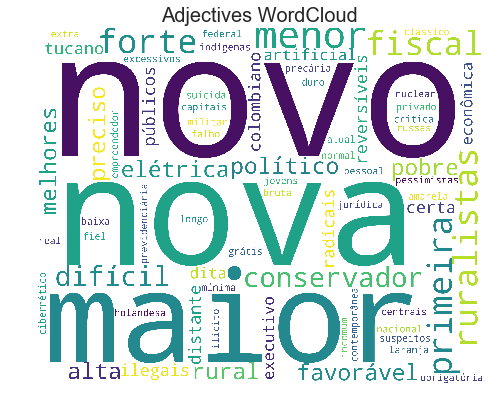

In [93]:
wordcloud_draw(adjectives, "white", "Adjectives WordCloud")

### Criação de uma nova coluna para a quantidade de Nomes de cada manchete

A função abaixo faz o split de cada manchete, conta os nomes sem as stopwords e atribui o valor númerico a uma nova coluna (Nouns_count)

In [94]:
nouns = []
def sub_count(sentence):
    headlines = [w for w in sentence.split() if w not in stopwords and w.isalpha()]
    adj_count = 0
    for word in headlines:
        try:
            if dict_morpho[word] == "N":
                adj_count += 1
                nouns.append(word)
        except:
            pass
    return adj_count
df['Nouns_Count'] = df['Headline'].apply(lambda x: sub_count(x))
df.head()

,Day,Month,Year,Company,Headline,Length,Length_Filtered,Adjectives_Count,Nouns_Count
0,1,fevereiro,2017,Valor,BNDES encolhe e volta ao nível de 20 anos atrás,10,7,0,3
1,1,fevereiro,2017,Valor,BC cria novo instrumento de política monetária.,7,6,1,2
2,1,fevereiro,2017,Valor,Câmbio gera bate-boca entre UA e UE.,7,5,0,0
3,1,fevereiro,2017,Valor,Indenização a transmissoras de energia já chega à tarifa.,9,5,0,2
4,1,fevereiro,2017,Valor,"Políticos esperam que relator separe ""joio do trigo"".",8,6,0,2


### Worcloud de Nomes

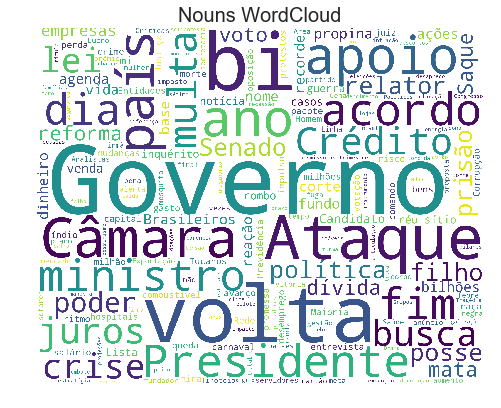

In [95]:
wordcloud_draw(nouns, "white", "Nouns WordCloud")

### Criação de uma nova coluna para a quantidade de Verbos de cada manchete

A função abaixo faz o split de cada manchete, conta os verbos sem as stopwords e atribui o valor númerico a uma nova coluna (Verbs_count)

In [96]:
verbs = []
def verb_count(sentence):
    headlines = [w for w in sentence.split() if w not in stopwords and w.isalpha()]
    adj_count = 0
    for word in headlines:
        try:
            if dict_morpho[word] == "V":
                adj_count += 1
                verbs.append(word)
        except:
            pass
    return adj_count
df['Verbs_Count'] = df['Headline'].apply(lambda x: verb_count(x))
df.head()

,Day,Month,Year,Company,Headline,Length,Length_Filtered,Adjectives_Count,Nouns_Count,Verbs_Count
0,1,fevereiro,2017,Valor,BNDES encolhe e volta ao nível de 20 anos atrás,10,7,0,3,0
1,1,fevereiro,2017,Valor,BC cria novo instrumento de política monetária.,7,6,1,2,1
2,1,fevereiro,2017,Valor,Câmbio gera bate-boca entre UA e UE.,7,5,0,0,1
3,1,fevereiro,2017,Valor,Indenização a transmissoras de energia já chega à tarifa.,9,5,0,2,1
4,1,fevereiro,2017,Valor,"Políticos esperam que relator separe ""joio do trigo"".",8,6,0,2,1


### Worcloud de Verbos

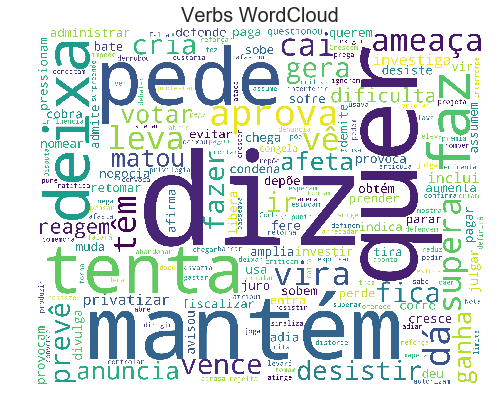

In [97]:
wordcloud_draw(verbs, "white", "Verbs WordCloud")

Podemos ver que o MAC Morpho nos forneceu um bom resultado classificando os tokens, mas poderia ser melhor especialmente ao lidar com verbos que não estejam na forma infinitiva. A lematização poderia resolver este problema, mas o NLTK não possui um bom suporte para a língua portuguesa em relação à prover verbos no infinitivo. Apesar de contar com recurso de stemming, este acaba também não sendo uma boa solução neste caso pois os dicionários utilizados não contém estas abreviações.

# Análise de frequência de palavras

Vamos apresentar as palavras mais frequentes nas manchetes dos jornais, assim como fizemos com as Word Clouds.
Porém, agora sem a utilização do MAC Morpho. Vamos apenas retirar as stopwords e identificar as palavras mais frequentes.

In [98]:
# Remove todas as stopwords
dataframe = pd.DataFrame(df['Headline'])

names = []
def funcao(sentence):
    stopwords = nltk.corpus.stopwords.words('portuguese')
    words = [w for w in sentence.lower().split() if w not in stopwords and w.isalpha()]
    return words

dataframe['stopwords'] = df['Headline'].apply(lambda x: funcao(x))

Através do método "FreqDist" da biblioteca NLTK podemos facilmente identificar a frequência das palavras, conforme mostrado abaixo. Obs: Por simplificação, estamos exibindo apenas as palavras que aparecem mais de cinco vezes.

In [99]:
all_words = []
for x in dataframe.stopwords:
    for y in x:
        all_words.append(y)

fd_words = nltk.FreqDist(all_words)
print ("Palavra, Frequência")
for i,x in enumerate(fd_words.most_common()):
    if x[1] > 5:
        print(x)

Palavra, Frequência
('diz', 21)
('temer', 19)
('trump', 18)
('governo', 17)
('é', 17)
('deve', 15)
('quer', 13)
('vai', 13)
('contra', 13)
('novo', 12)
('sobre', 12)
('volta', 11)
('doria', 11)
('brasil', 11)
('bi', 11)
('pode', 10)
('país', 9)
('mantém', 9)
('eua', 8)
('stf', 8)
('sp', 8)
('câmara', 8)
('vão', 8)
('odebrecht', 8)
('ataque', 8)
('crise', 7)
('ter', 7)
('pede', 7)
('tenta', 7)
('apoio', 7)
('bc', 6)
('após', 6)
('nova', 6)
('presidente', 6)
('jbs', 6)
('acordo', 6)
('fim', 6)
('fgts', 6)
('deixa', 6)
('febre', 6)


** Esta análise nos permite visualizar as palavras que teriam maior relevância no corpus e, talvez, poderiam ser adicionadas e/ou modificadas nos dicionários léxicos que veremos adiante. No entanto, já adiantamos que é um tanto quanto inviável adicionar estas palavras aos dicionários, visto que a maioria são nomes e não encontramos uma forma fácil de rotular estas palavras. **

## Identificação de manchetes repetidas

Identificamos a existência de 12 manchetes repetidas no dataset. Uma abordagem para corrigir o problema seria identificar qual é a notícia verdadeira (pertencente ao jornal original) e remover a falsa. Porém, optamos por manter o dataset original, uma vez que teríamos que realizar um trabalho manual de verificação ou a criação de um parser para buscar as notícias verdadeiras.

In [100]:
aux = df[['Company','Headline']][df.Headline.duplicated(keep=False)] #value_counts(sort=True)
print ("The dataset has", aux.Headline.count(),"news duplicated")

aux.sort_values("Headline",ascending=True)

The dataset has 24 news duplicated


,Company,Headline
490,Estado,Contas do govertno têm maior rombo da história.
434,Valor,Contas do govertno têm maior rombo da história.
488,Estado,Contas inativas do FGTS devem injetar R$ 41 bi na economia.
432,Valor,Contas inativas do FGTS devem injetar R$ 41 bi na economia.
435,Valor,"Doria congela R$ 2,6 bi de Saúde e Educação."
491,Estado,"Doria congela R$ 2,6 bi de Saúde e Educação."
87,Valor,EUA vão fiscalizar Odebrecht e Braskem.
448,Globo,EUA vão fiscalizar Odebrecht e Braskem.
413,Folha,Embaixada do Brasil cria plano de fuga da Coreia.
416,Folha,Embaixada do Brasil cria plano de fuga da Coreia.


# Análise Léxica

Os arquivos referentes aos dicionários léxicos foram baseados em https://github.com/pedrobalage/STIL_LIWC_Evaluation, sendo:
- OpLexiconReader - OPLexicon 3.0 [4]
- SentiLexReader - Sentilex PT02 [5]
- LiwcReader - Linguistic Inquiry and Word Count [6]

Estes dicionários apresentam características semelhantes entre si, como a presença de polaridades para algumas palavras e em alguns casos para algumas expressões. Em ambos, as polaridades são expressas como:

- -1: Sentimento negativo
- 0: Sentimento Neutro
- 1: Sentimento Positivo

In [101]:
#import lexical
from lexical import OpLexiconReader
from lexical import SentiLexReader
from lexical import LiwcReader

#### Exemplo do OpLexicon 3.0

In [102]:
oplexicon = OpLexiconReader()
sentence = df["Headline"][1].split()
for w in sentence:
    print(w, oplexicon.polarity(w))

BC None
cria None
novo 1
instrumento None
de None
política 0
monetária. None


#### Exemplo do SentiLex PT02

In [103]:
sentilex =  SentiLexReader()
for w in sentence:
    print(w, sentilex.polarity(w))

BC None
cria None
novo None
instrumento None
de None
política None
monetária. None


#### Exemplo do LIWC

In [104]:
liwc =  LiwcReader()
for w in sentence:
    print(w, liwc.polarity(w))

BC None
cria 1
novo 0
instrumento 0
de 0
política 0
monetária. None


Os exemplos acima nos alerta que várias palavras não estão presentes nos dicionários léxicos (None), o que afeta bastante a eficácia de análise de polaridade. Entretanto, iremos tentar realizar análise de sentimentos baseado neles.

# Análise de sentimento

A função abaixo retorna a polaridade de acordo com o dicionário léxico passado. Com objetivo de manter as dimensões entre -1 e 1, nós decidimos realizar a soma de todas as polaridades e tirar a média relacionada às palavras contidas nos dicionários.

Portanto, palavras que não estão presentes nos dicionários não influenciam na média final. Deste modo, a análise de sentimento usando os dicionários léxicos existentes puderam ser melhorados, mesmo com a inexistência de alguns termos e palavras.

As três últimas colunas criadas exibem o score de cada manchete de acordo com o respectivo dicionário utilizado.

In [105]:
def extract_sentiment_lexical(sentence, lexical):
    model = oplexicon if lexical == "oplexicon" else liwc if lexical =="liwc" else sentilex
    original_words = sentence.split()
    stopwords = nltk.corpus.stopwords.words('portuguese')
    #words = [w for w in original_words] 
    words = [w for w in original_words if w not in stopwords and w.isalpha()]  

    sum_lexical, count_lexical = 0, 0
    for w in words:
        pol_lexical = model.polarity(w)
        if pol_lexical is not None:
            sum_lexical += pol_lexical
            count_lexical += 1
        
    mean_lexical = sum_lexical/count_lexical if count_lexical != 0 else 0
    #print(sentence, mean_lexical)
    return mean_lexical
    
df['OpLexicon_Score'] = df['Headline'].apply(lambda x: extract_sentiment_lexical(x, "oplexicon"))
df['SentiLex_Score'] = df['Headline'].apply(lambda x: extract_sentiment_lexical(x, "sentilex"))
df['LIWC_Score'] = df['Headline'].apply(lambda x: extract_sentiment_lexical(x, "liwc"))
df.head()

,Day,Month,Year,Company,Headline,Length,Length_Filtered,Adjectives_Count,Nouns_Count,Verbs_Count,OpLexicon_Score,SentiLex_Score,LIWC_Score
0,1,fevereiro,2017,Valor,BNDES encolhe e volta ao nível de 20 anos atrás,10,7,0,3,0,0.0,0.0,-0.20
1,1,fevereiro,2017,Valor,BC cria novo instrumento de política monetária.,7,6,1,2,1,0.5,0.0,0.25
2,1,fevereiro,2017,Valor,Câmbio gera bate-boca entre UA e UE.,7,5,0,0,1,0.0,0.0,1.00
3,1,fevereiro,2017,Valor,Indenização a transmissoras de energia já chega à tarifa.,9,5,0,2,1,0.0,1.0,0.50
4,1,fevereiro,2017,Valor,"Políticos esperam que relator separe ""joio do trigo"".",8,6,0,2,1,0.0,0.0,0.00


### Análise ao longo do tempo

Com o objetivo de entender as mudanças de sentimento relacionadas às manchetes ao longo do tempo, foi proposta uma visualização definida através dos meses (sendo estes transformados para o formato adequado) juntamente com uma análise comparativa da polaridade resultante de cada dicionário léxico.

In [106]:
import datetime as dt

dict1 = {'janeiro':1,
         'fevereiro':2,
         'março':3, 
         'abril':4,
         'maio':5,
         'junho':6,
         'julho':7,
         'agosto':8,
         'setembro':9,
         'outubro':10, 
         'novembro':11,
         'dezembro':12}
df['Month_number'] = df.Month.map(dict1)

#df.head()

In [107]:
df['DateTime'] = df[['Year', 'Month_number', 'Day']].apply(lambda s : dt.datetime(*s),axis = 1)
#df.head()

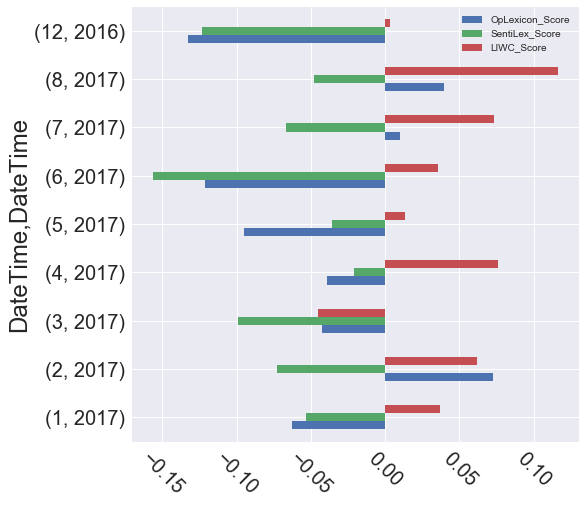

In [108]:
df.index = df.DateTime

#ax = df.set_index(df.Month).sort_index().groupby("Month",sort=False, axis=0)["OpLexicon_Score","SentiLex_Score","LIWC_Score"].mean().plot(kind="barh", figsize=(8, 8))
ax = pd.Series.groupby(df,by=[df.index.month,df.index.year],sort=True, axis=0)["OpLexicon_Score","SentiLex_Score","LIWC_Score"].mean().plot(kind="barh", figsize=(8, 8))

# resize y label
ylabel = ax.yaxis.get_label()
ylabel.set_fontsize(24)


# resize x tick labels
labels = ax.yaxis.get_ticklabels()
[label.set_fontsize(20) for label in labels];

# resize y tick labels
labels = ax.xaxis.get_ticklabels()
[label.set_fontsize(20) for label in labels]
[label.set_rotation(-45) for label in labels];

Pode-se notar analisando a figura acima, que não só existe muita variação entre o resultado de polaridade do sentimento para cada dicionário léxico, como também existe uma tendência que a análise de sentimento de um contexto geral se aproxime de neutro, já que valores entre -0.15 e 0.15 estão bem próximos ao valor padrão assumido para neutro que seria 0.

Podemos notar que apenas no mês de Março de 2017 todos os dicionários apontaram uma pequena tendência de manchetes negativas, vamos exibir algumas abaixo:

In [109]:
df.loc[(df["LIWC_Score"] <0) &  (df["SentiLex_Score"] <0) & (df["OpLexicon_Score"] <0) & (df["Month_number"]==3),"Headline"]


DateTime
2017-03-01    Trump pode desistir de expulsar ilegais sem crime grave.      
2017-03-15    Temer pode desistir de políticos para Itaipu.                 
2017-03-15    Tratamento contra câncer é falho no rio.                      
2017-03-15    Casos de suspeita de dengue e zika caem, em média, 90% no ano.
Name: Headline, dtype: object

### Comparação entre os dicionários léxicos

Para afirmar a hipótese de que cada dicionário léxico apresenta resultados diferentes e que também o contexto geral das manchetes tende ao sentimento neutro, é proposto abaixo histogramas demonstrando a distribuição de sentimento no dataset.

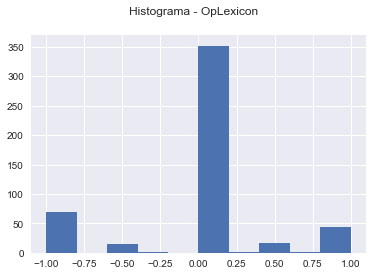

In [110]:
plt.subplot()
df["OpLexicon_Score"].hist()
plt.suptitle("Histograma - OpLexicon")

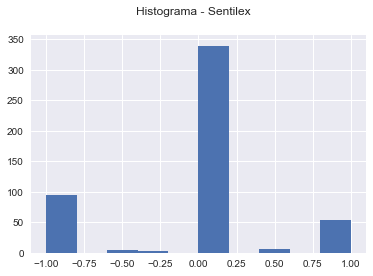

In [111]:
df["SentiLex_Score"].hist()
plt.suptitle("Histograma - Sentilex")

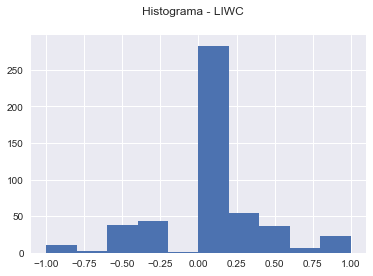

In [112]:
df["LIWC_Score"].hist()
plt.suptitle("Histograma - LIWC")

Primeiramente, de uma forma geral, todos os dicionários apresentaram uma quantidade muito elevada de manchetes neutras. Pode-se assumir duas possíveis conclusões em relação a isto:
- As manchetes apresentam poucas palavras contidas nos dicionários léxicos, portanto com a inexistência destas palavras acaba-se assumindo o valor padrão 0 para neutro.
- Notícias de economia e política estão predominantemente presentes no conjunto de dados sendo as manchetes destas, na sua maior parte, compostas por palavras neutras.

Pode-se observar também que os dicionários apresentam certa divergência entre si, principalmente quando se relaciona o LIWC com os demais. Nota-se uma distribuição menos discretizada em -1, 0 e 1 no dicionário léxico do LIWC, devido ao fato deste conter um número de palavras maior e que se assemelham mais com as manchetes propostas.

## Análise de Score por Dicionário

Vamos apresentar o score médio de cada Jornal de acordo com cada dicionário léxico.

### Dicionário OpLexicon

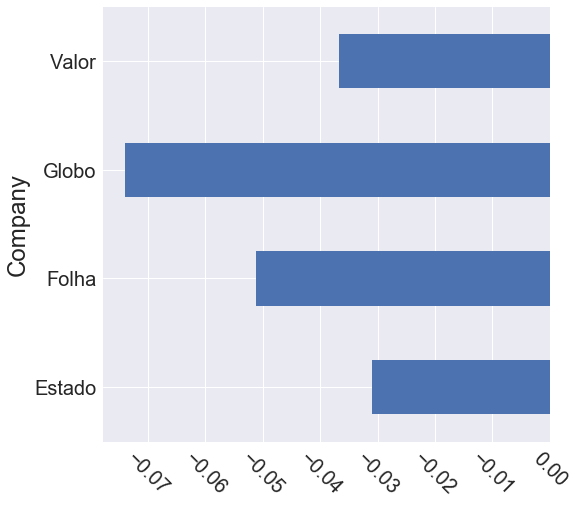

In [113]:
ax = df.groupby("Company")["OpLexicon_Score"].mean().plot(kind="barh", figsize=(8, 8))

# resize y label
ylabel = ax.yaxis.get_label()
ylabel.set_fontsize(24)

# resize x tick labels
labels = ax.yaxis.get_ticklabels()
[label.set_fontsize(20) for label in labels];

# resize y tick labels
labels = ax.xaxis.get_ticklabels()
[label.set_fontsize(20) for label in labels]
[label.set_rotation(-45) for label in labels];

### Dicionário Sentilex

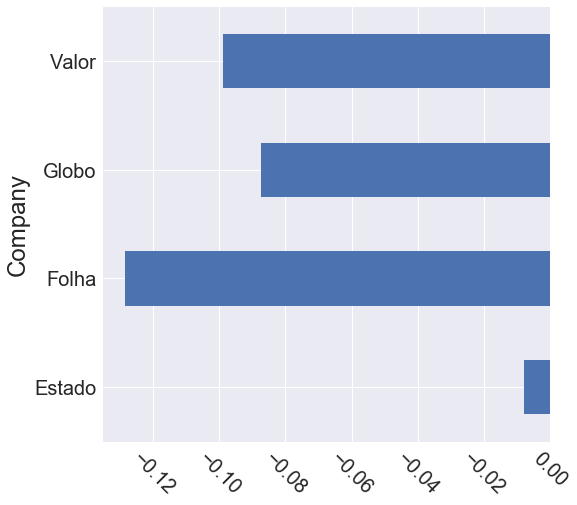

In [114]:
ax = df.groupby("Company")["SentiLex_Score"].mean().plot(kind="barh", figsize=(8, 8))

# resize y label
ylabel = ax.yaxis.get_label()
ylabel.set_fontsize(24)

# resize x tick labels
labels = ax.yaxis.get_ticklabels()
[label.set_fontsize(20) for label in labels];

# resize y tick labels
labels = ax.xaxis.get_ticklabels()
[label.set_fontsize(20) for label in labels]
[label.set_rotation(-45) for label in labels];

### Dicionário LIWC

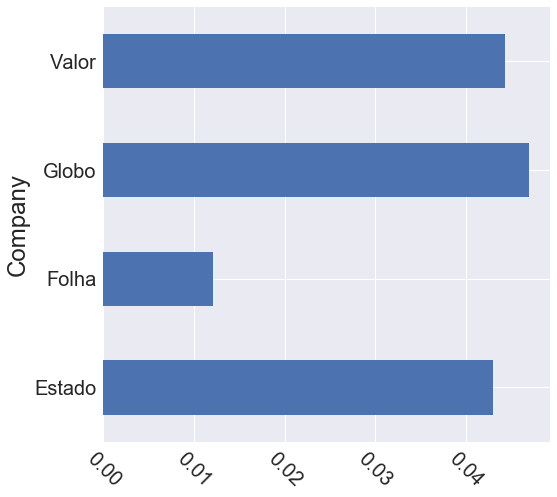

In [115]:
ax = df.groupby("Company")["LIWC_Score"].mean().plot(kind="barh", figsize=(8, 8))

# resize y label
ylabel = ax.yaxis.get_label()
ylabel.set_fontsize(24)

# resize x tick labels
labels = ax.yaxis.get_ticklabels()
[label.set_fontsize(20) for label in labels];

# resize y tick labels
labels = ax.xaxis.get_ticklabels()
[label.set_fontsize(20) for label in labels]
[label.set_rotation(-45) for label in labels];

Como já mencionado anteriormente, os dicionários apresentam certa divergência entre si, principalmente quando se relaciona o LIWC com os demais. Neste caso, o LIWC apresentou média mais positiva para todos os Jornais, enquanto que os outros dois apresentaram médias mais negativas.

# Classificação da valência das manchetes

Como o dicionário LIWC apresenta um maior número de palavras e seguindo a observação feita anteriormente da distribuição no histograma, pode ser feita uma classificação de acordo com os critérios:
- -1 <= score <= -0.35 = Negativa
- -0.35 < score < 0.35 = Neutra
- 0.35 <= score <= 1 = Positiva

Abaixo tem-se algumas manchetes contidas no dataset e suas respectivas valências e scores de polaridades:

In [116]:
def valence_classification(score):
    if -1 <= score and score <= -0.35:
        return "Negativa"
    if -0.35 < score and score < 0.35:
        return "Neutra"
    if 0.35 <= score and score <= 1:
        return "Positiva"

df['LIWC_Valence'] = df['LIWC_Score'].apply(lambda x: valence_classification(x))
df[['Headline','LIWC_Valence', 'LIWC_Score']]

,Headline,LIWC_Valence,LIWC_Score
DateTime,,,
2017-02-01,BNDES encolhe e volta ao nível de 20 anos atrás,Neutra,-0.200000
2017-02-01,BC cria novo instrumento de política monetária.,Neutra,0.250000
2017-02-01,Câmbio gera bate-boca entre UA e UE.,Positiva,1.000000
2017-02-01,Indenização a transmissoras de energia já chega à tarifa.,Positiva,0.500000
2017-02-01,"Políticos esperam que relator separe ""joio do trigo"".",Neutra,0.000000
2017-02-01,Philips quer administrar hospitais públicos no Brasil.,Positiva,0.500000
2017-02-01,"Com vendas em queda, C&amp;C muda lojas e troca diretoria.",Neutra,-0.250000
2017-02-01,Fachin poderá ir para turma que julga Lava-Jato.,Neutra,-0.250000
2017-02-01,Eike tem multas que superam fundo para prisões.,Positiva,0.500000


# Conclusão

Este trabalho nos elucidou o quão complexo é a classificação de texto em emoções. Vamos resumir as lições aprendidas e o que ainda pode ser melhorado.

O contato com novas bibliotecas, a NLTK por exemplo, foi muito válido pois nos ajudou com diversas tarefas de manipulação de texto, como o uso de stopwords.

Quanto ao modo de atribuir valência às frases podemos discutir sobre os pontos fracos e fortes:
* Apesar da existência de dicionários léxicos para a Língua Portuguesa, não conseguimos uma distribuição tão satisfatória, ou seja, a maioria das manchetes foram classificadas em torno da valência 0 (zero).
* O dicionário LIWC teve uma melhor distribuição em relação ao outros dois (OpLexicon e SentiLex) e atribuimos isso ao fato de possuir maior quantidade de palavras:
    * OpLexicon: cerca de 32.000 palavras
    * SentiLex: cerca de 82.000 palavras
    * LIWC: cerca de 127.000 palavras
* Outra possível explicação para o acúmulo em torno da valência 0 é o fato das manchetes serem curtas, ou seja, temos poucas palavras nas manchetes, as quais nem sempre conseguimos extrair informação dos dicionários. Por exemplo, o Jornal "Folha de São Paulo" apresentou sete palavras como a maior média comparada aos outros jornais.
* Acreditamos que se as notícias em si fossem analisadas teríamos um resultado mais disperso, ou seja, menos centralizado na valência 0, pois teríamos muito mais palavras sendo categorizadas de acordo com os dicionários e as médias de valências provavelmente seriam maiores (em módulo). No entanto, é apenas um sentimento baseado no experimento das manchetes e não testamos de forma empiríca esta hipótese.

Acreditamos que o aprendizado foi muito válido e servirá de base para diversas aplicações, como por exemplo a que foi desenvolvida abaixo como uma extensão da análise de sentimento de manchetes, porém em tempo real.

# Análise de Sentimentos de Manchetes em Tempo Real

Este trabalho inspirou a criação de uma ferramenta de análise de sentimentos em tempo real, ou seja, podemos comparar quais são as notícias mais importantes e suas polaridades no dia de hoje.

Abaixo segue a análise para os Jornais Valor Econômico, O Globo, Folha de São Paulo e Estadão

In [117]:
def parser(website):
    r = requests.get(website)
    content = r.content
    soup = BeautifulSoup(content, "html.parser")
    headings = soup.find_all(re.compile(r"^h\d$"))
    company = []
    for h in headings:
        # avoid ads
        if len(h.text.strip().split()) > 6:
            company.append(str.strip(h.text))
    return company

In [118]:
valor_news = parser("http://www.valor.com.br/")
globo_news = parser("https://oglobo.globo.com/")
folha_news = parser("http://www.folha.uol.com.br/")
estadao_news = parser("http://www.estadao.com.br/")

## Folha Top 10

In [119]:
data = []
cols = ['Sentence', 'OpLexicon', 'Sentilex', 'LIWC']
for sentence in folha_news[:10]:
    score_oplexicon = extract_sentiment_lexical(sentence, "oplexicon")
    score_sentilex = extract_sentiment_lexical(sentence, "sentilex")
    score_liwc = extract_sentiment_lexical(sentence, "liwc")
    data.append([sentence, score_oplexicon, score_sentilex, score_liwc])
df = pd.DataFrame(data, columns=cols)
df.head(10)

,Sentence,OpLexicon,Sentilex,LIWC
0,Janot denuncia Temer e o acusa de chefiar organização criminosa,0.0,-0.5,-0.250000
1,"Nova denúncia é recheada de absurdos, afirma Michel Temer",1.0,0.0,0.000000
2,Presidente mantém no governo os ministros denunciados,0.0,0.0,0.333333
3,"'Os mortos, deixai-os a seus cuidados', diz Janot a Gilmar",0.0,0.0,0.000000
4,"Para defesa de Joesley, Janot usurpou competência do Supremo",-1.0,0.0,0.333333
5,"Janot rescinde acordo da JBS, mas diz que provas continuam válidas",1.0,1.0,0.200000
6,Palocci diz que aprendeu com Lula a 'não falar'; veja frases dos dois,0.0,0.0,0.000000
7,Novo míssil disparado pela Coreia do Norte sobrevoa o Japão,0.0,0.0,0.000000
8,Nova provocação é desafio e indica que Kim Jong-un afia suas armas,0.0,-1.0,0.000000
9,Promotoria abre procedimento para apurar viagens de Doria,1.0,0.0,0.333333


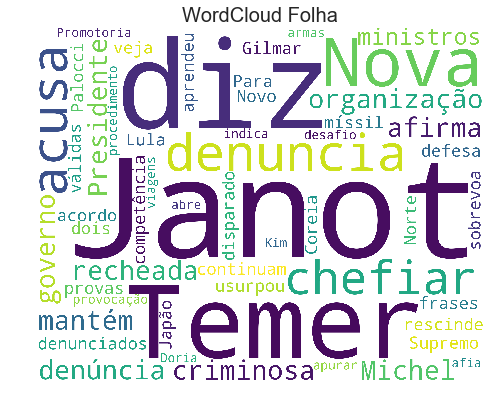

In [120]:
words = []
for sentence in folha_news[:10]:
    for w in sentence.split():
        if w not in stopwords and w.isalpha():
            words.append(w) 
        
wordcloud_draw(words, "white" ,"WordCloud Folha")

## Valor Top 10

In [121]:
data = []
cols = ['Sentence', 'OpLexicon', 'Sentilex', 'LIWC']
for sentence in valor_news[:10]:
    score_oplexicon = extract_sentiment_lexical(sentence, "oplexicon")
    score_sentilex = extract_sentiment_lexical(sentence, "sentilex")
    score_liwc = extract_sentiment_lexical(sentence, "liwc")
    data.append([sentence, score_oplexicon, score_sentilex, score_liwc])
df = pd.DataFrame(data, columns=cols)
df.head(10)

,Sentence,OpLexicon,Sentilex,LIWC
0,Segunda denúncia contra Temer diz que presidente é líder de organização criminosa,-0.333333,-1.0,0.000000
1,"Gerdau pagou ao PMDB por regra de dívida fiscal, diz denúncia da PGR",0.000000,0.0,0.000000
2,Rodrigo Janot revoga delações de Joesley e Saud e revisa a de Francisco de Assis,0.000000,0.0,0.000000
3,"Articulação para cobrar propina de empresários coube a Padilha, aponta denúncia",1.000000,0.0,0.000000
4,PMDB diz lamentar 'mais um ato de irresponsabilidade' de Rodrigo Janot,0.000000,-1.0,-0.333333
5,"Fux, do STF, vê 'veementes indícios' de prática de crimes por Blairo Maggi (foto)",1.000000,1.0,0.000000
6,Coreia do Norte lança de novo míssil em direção ao Japão,1.000000,0.0,0.000000
7,Ministério da Cultura quer regulamentar cobrança para empresas como Netflix,1.000000,0.0,0.333333
8,BNDES: Troca de ativos é possibilidade para devolver recursos à União,0.500000,1.0,0.000000
9,Cade aprova acordo entre Latam e American Airlines,0.000000,0.0,0.500000


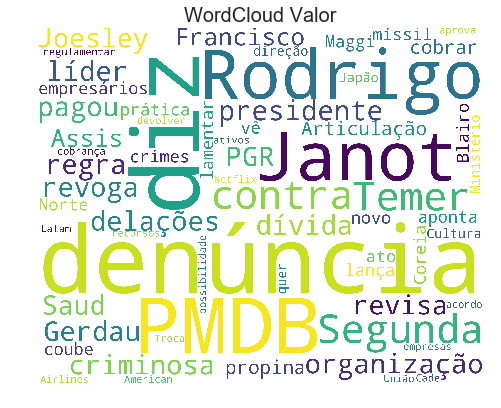

In [122]:
words = []
for sentence in valor_news[:10]:
    for w in sentence.split():
        if w not in stopwords and w.isalpha():
            words.append(w) 
        
wordcloud_draw(words, "white" ,"WordCloud Valor")

## O Globo Top 10

In [123]:
data = []
cols = ['Sentence', 'OpLexicon', 'Sentilex', 'LIWC']
for sentence in globo_news[:10]:
    score_oplexicon = extract_sentiment_lexical(sentence, "oplexicon")
    score_sentilex = extract_sentiment_lexical(sentence, "sentilex")
    score_liwc = extract_sentiment_lexical(sentence, "liwc")
    data.append([sentence, score_oplexicon, score_sentilex, score_liwc])
df = pd.DataFrame(data, columns=cols)
df.head(10)

,Sentence,OpLexicon,Sentilex,LIWC
0,Janot denuncia Michel Temer ao Supremo pela segunda vez,0.0,0.0,0.000000
1,"Lauro Jardim: Temer prometeu demitir os ministros denunciados, mas...",-1.0,0.0,0.500000
2,Lauro Jardim: STF vai julgar prisão de Aécio,0.0,-1.0,-0.333333
3,Temer pede suspensão de envio de segunda denúncia de Janot para Câmara,0.0,0.0,-0.500000
4,Procurador-geral da República rescinde delações de Joesley e Saud,0.0,0.0,0.000000
5,STJ autoriza inquérito contra Pezão baseado na delação da Odebrecht,0.0,0.0,0.000000
6,Lula manda mensagem de solidariedade a Garotinho,0.0,0.0,0.000000
7,Ciro ataca Lula e descarta aliança com PT,0.0,1.0,-1.000000
8,Teste nuclear norte-coreano modificou formato de montanha,0.0,0.0,0.000000
9,"Coreia do Norte dispara novo míssil, que sobrevoa Japão",1.0,0.0,0.000000


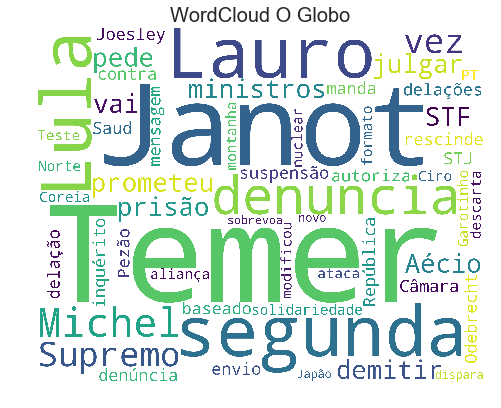

In [124]:
words = []
for sentence in globo_news[:10]:
    for w in sentence.split():
        if w not in stopwords and w.isalpha():
            words.append(w) 
        
wordcloud_draw(words, "white" ,"WordCloud O Globo")

## Estadão Top 10

In [125]:
data = []
cols = ['Sentence', 'OpLexicon', 'Sentilex', 'LIWC']
for sentence in estadao_news[:10]:
    score_oplexicon = extract_sentiment_lexical(sentence, "oplexicon")
    score_sentilex = extract_sentiment_lexical(sentence, "sentilex")
    score_liwc = extract_sentiment_lexical(sentence, "liwc")
    data.append([sentence, score_oplexicon, score_sentilex, score_liwc])
df = pd.DataFrame(data, columns=cols)
df.head(10)

,Sentence,OpLexicon,Sentilex,LIWC
0,Estadão - Portal do Estado de S. Paulo,0.0,0.0,0.00
1,Janot faz 2ª denúncia e aponta Temer como líder de organização criminosa,-0.5,-1.0,0.00
2,"PMDB apoiou o impeachment para tentar barrar a Lava Jato, diz Janot",0.0,0.0,0.00
3,Janot: Sabia de custo de enfrentar modelo corrupto,-0.5,0.0,-0.25
4,Coreia do Norte dispara míssil; Japão faz alerta,1.0,0.0,0.00
5,Fux cita 'veementes indícios' de crimes de Blairo,0.0,0.0,0.00
6,Ministério Público investiga viagens de Doria durante expediente,0.0,0.0,0.00
7,Geddel alega risco de 'estupro' para deixar a prisão,0.0,-1.0,0.00
8,Fãs choram após Lady Gaga cancelar show no Rio,-1.0,-1.0,-0.25
9,"Jovens são os mais afetados pela crise econômica, diz Ipea",-1.0,-1.0,0.00


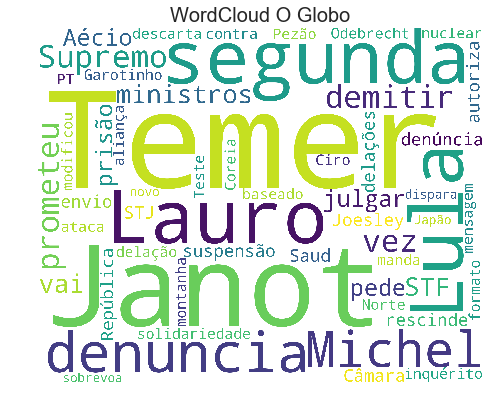

In [126]:
words = []
for sentence in globo_news[:10]:
    for w in sentence.split():
        if w not in stopwords and w.isalpha():
            words.append(w) 
        
wordcloud_draw(words, "white" ,"WordCloud O Globo")

## Referências
    [1] "Manchetes Brasil", by Paula Dornhofer Paro Costa (Costa, P.D.P.), 2017
    [2] http://www.agenciamestre.com/seo/stop-words-como-funcionam-palavras-de-parada/
    [3] http://nilc.icmc.usp.br/macmorpho/
    [4] http://ontolp.inf.pucrs.br/Recursos/downloads-OpLexicon.php
    [5] http://xldb.fc.ul.pt/wiki/SentiLex-PT01
    [6] http://www.nilc.icmc.usp.br/portlex/index.php/pt/projetos/liwc